# Import Libs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

#Data Load

In [ ]:
from google.colab import files
uploaded = files.upload()
# You can select multiple files to upload at once.

Saving streamworks_user_data.csv to streamworks_user_data.csv


In [ ]:
df = pd.read_csv('streamworks_user_data.csv')

In [ ]:
df.head()
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               1498 non-null   float64       
 1   age                   1497 non-null   float64       
 2   gender                1499 non-null   object        
 3   signup_date           1498 non-null   datetime64[ns]
 4   last_active_date      1498 non-null   datetime64[ns]
 5   country               1497 non-null   object        
 6   subscription_type     1497 non-null   object        
 7   average_watch_hours   1496 non-null   float64       
 8   mobile_app_usage_pct  1498 non-null   float64       
 9   complaints_raised     1497 non-null   float64       
 10  received_promotions   1497 non-null   object        
 11  referred_by_friend    1497 non-null   object        
 12  is_churned            1499 non-null   float64       
 13  monthly_fee       

,0
user_id,2
age,3
gender,1
signup_date,2
last_active_date,2
country,3
subscription_type,3
average_watch_hours,4
mobile_app_usage_pct,2
complaints_raised,3


In [ ]:
# Convert date columns to datetime objects, coercing errors
df['signup_date'] = pd.to_datetime(df['signup_date'], errors='coerce')
df['last_active_date'] = pd.to_datetime(df['last_active_date'], errors='coerce')

# Calculate tenure in days
df['tenure_days'] = (df['last_active_date'] - df['signup_date']).dt.days

# Create 'is_loyal' feature based on tenure
df['is_loyal'] = (df['tenure_days'] > 180).astype(int)

# Display the new columns and check for any missing values introduced
print(df[['signup_date', 'last_active_date', 'tenure_days', 'is_loyal']].head())
print("\nMissing values after creating new features:")
print(df[['tenure_days', 'is_loyal']].isnull().sum())

  signup_date last_active_date  tenure_days  is_loyal
0  2025-02-04       2025-07-13        159.0         0
1  2023-02-01       2025-07-13        893.0         1
2  2022-08-21       2025-07-13       1057.0         1
3  2023-09-14       2025-07-13        668.0         1
4  2023-07-29       2025-07-13        715.0         1

Missing values after creating new features:
tenure_days    4
is_loyal       0
dtype: int64


In [ ]:
# Fill missing 'monthly_fee' values with the mean
df['monthly_fee'].fillna(df['monthly_fee'].mean(), inplace=True)

# Verify that missing values in 'monthly_fee' are handled
print("Missing values after handling 'monthly_fee':")
print(df.isnull().sum())

Missing values after handling 'monthly_fee':
user_id                 2
age                     3
gender                  1
signup_date             2
last_active_date        2
country                 3
subscription_type       3
average_watch_hours     4
mobile_app_usage_pct    2
complaints_raised       3
received_promotions     3
referred_by_friend      3
is_churned              1
monthly_fee             0
tenure_days             4
is_loyal                0
dtype: int64


/tmp/ipython-input-57-2128626022.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['monthly_fee'].fillna(df['monthly_fee'].mean(), inplace=True)


#Check Churn

In [ ]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['gender'], df['is_churned'])
chi2, p, dof, ex = chi2_contingency(contingency)

df['is_churned'].value_counts()

print(f"Chi-square p-value for gender vs churn: {p}")

df['is_churned'].sum()

Chi-square p-value for gender vs churn: 0.12450962735089596


np.float64(351.0)

In [ ]:
from scipy.stats import ttest_ind

# Separate 'average_watch_hours' for churned and retained users
churned = df[df['is_churned'] == 1]['average_watch_hours'].dropna()
retained = df[df['is_churned'] == 0]['average_watch_hours'].dropna()

# Perform the independent samples t-test
t_stat, p_val = ttest_ind(churned, retained)

# Print the p-value
print(f"P-value from t-test for average_watch_hours vs churn: {p_val}")

P-value from t-test for average_watch_hours vs churn: 0.8565011901364149


#Visualize Churn
This shows if there’s a visual difference in watch time between those who churned vs not. If churners tend to watch less, that could be a key predictor.

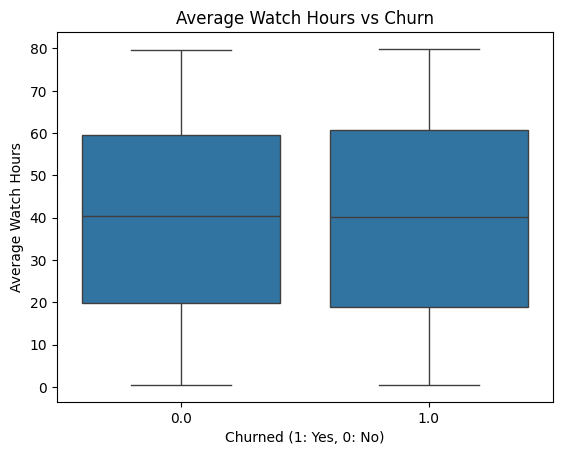

In [ ]:
# Boxplot for average_watch_hours vs churn
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='is_churned', y='average_watch_hours', data=df)
plt.title('Average Watch Hours vs Churn')
plt.xlabel('Churned (1: Yes, 0: No)')
plt.ylabel('Average Watch Hours')
plt.show()

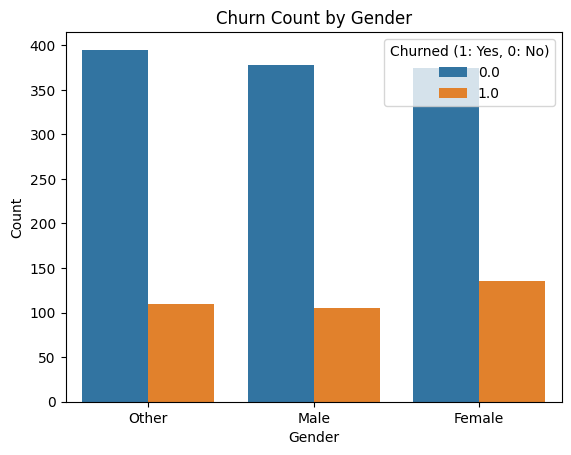

In [ ]:
# Bar plot for gender vs churn
sns.countplot(x='gender', hue='is_churned', data=df)
plt.title('Churn Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churned (1: Yes, 0: No)')
plt.show()

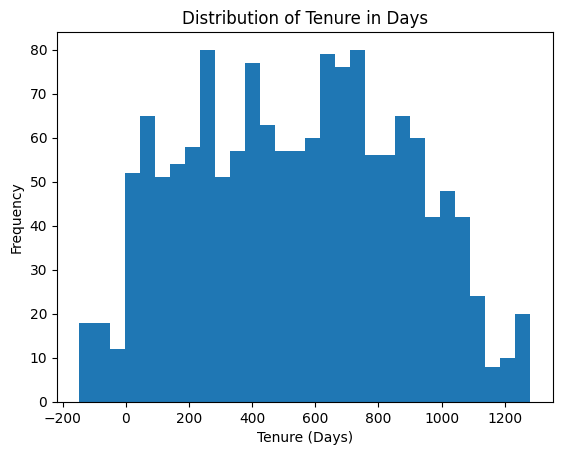

In [ ]:
# Histogram for tenure_days
import matplotlib.pyplot as plt

plt.hist(df['tenure_days'].dropna(), bins=30) # Drop NaNs for plotting
plt.title('Distribution of Tenure in Days')
plt.xlabel('Tenure (Days)')
plt.ylabel('Frequency')
plt.show()

correlation matrix and heatmap

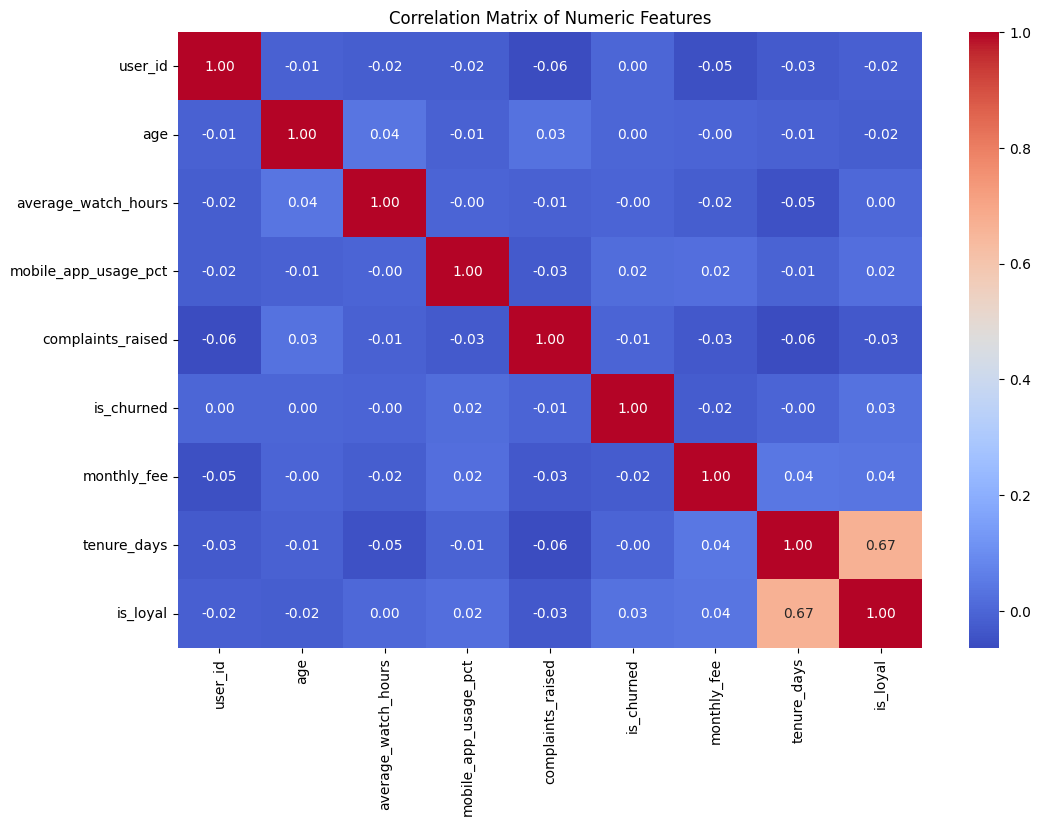

In [ ]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Feature Selection
X = features used to predict

y = target variable (churn)

In [ ]:
features = ['average_watch_hours', 'age', 'subscription_type', 'is_loyal']
X = df[features]
y = df['is_churned']

df['is_loyal'] = df['tenure_days'] > 180
df['is_loyal'] = df['is_loyal'].astype(int)  # convert to 0/1


In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table for referred_by_friend and is_churned
contingency_referred = pd.crosstab(df['referred_by_friend'], df['is_churned'])

# Perform the chi-squared test
chi2_referred, p_referred, dof_referred, ex_referred = chi2_contingency(contingency_referred)

# Print the p-value
print(f"Chi-square p-value for referred_by_friend vs churn: {p_referred}")

Chi-square p-value for referred_by_friend vs churn: 0.405299011140109


In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table of gender and is_churned
contingency = pd.crosstab(df['gender'], df['is_churned'])

# Perform the chi-squared test
chi2, p, dof, ex = chi2_contingency(contingency)

# Print the p-value
print(f"Chi-square p-value for gender vs churn: {p}")

Chi-square p-value for gender vs churn: 0.12450962735089596


In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table for received_promotions and is_churned
contingency_promotions = pd.crosstab(df['received_promotions'], df['is_churned'])

# Perform the chi-squared test
chi2_promotions, p_promotions, dof_promotions, ex_promotions = chi2_contingency(contingency_promotions)

# Print the p-value
print(f"Chi-square p-value for received_promotions vs churn: {p_promotions}")

Chi-square p-value for received_promotions vs churn: 0.14149449247272147


#Encoding Categorical Variables |

If subscription_type is text (e.g. 'Basic', 'Premium'), it needs to be converted to numbers.

In [ ]:
X = pd.get_dummies(X, drop_first=True)

#Train Test Split

 Training set: the model learns from this.

Test set: you check how good it is on unseen data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Build

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Drop rows with missing values in X_train and y_train
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index] # Ensure y_train corresponds to the filtered X_train

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Prediction Making

In [ ]:
# Concatenate X_test and y_test to drop rows with missing values together
test_df = pd.concat([X_test, y_test], axis=1).dropna()

# Separate X_test and y_test again
X_test = test_df[X_test.columns]
y_test = test_df[y_test.name]

y_pred = model.predict(X_test)

#Evaluation


In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[220   0]
 [ 78   0]]
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85       220
         1.0       0.00      0.00      0.00        78

    accuracy                           0.74       298
   macro avg       0.37      0.50      0.42       298
weighted avg       0.55      0.74      0.63       298



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Feature Importance

In [ ]:
importance = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_[0]})
importance.sort_values(by='coefficient', ascending=False)

,feature,coefficient
2,is_loyal,0.336543
4,subscription_type_Standard,0.052887
1,age,0.003043
0,average_watch_hours,-0.002704
3,subscription_type_Premium,-0.146913


# ROC Curve

Text(0.5, 1.0, 'ROC Curve')

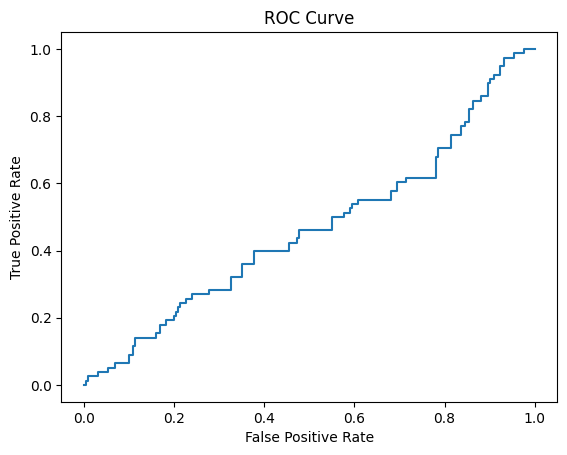

In [ ]:
from sklearn.metrics import roc_curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')


#AUC

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc}")

AUC: 0.5
